# Model Evaluation Over Time 
Load various checkpoints and see how the model and predicted different actions over time.
Important to see whether the model is learning in the correct direction.

In [1]:
# Load all the inputs

import pathlib
import os
import nest_asyncio

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.ppo import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.policies import obs_as_tensor

nest_asyncio.apply()

Loaded layouts
Loaded layouts


In [2]:
# Load Evaluation States
#pathlib.Path("evaluations").mkdir(parents=True, exist_ok=True)
checkpoints = [f[:-6] for f in os.listdir("evaluations") if os.path.isfile(os.path.join("evaluations", f)) and f.endswith(".state")]
checkpoints = [(f,f + '.state', f + '.pkl') for f in checkpoints if os.path.isfile(os.path.join("evaluations", f + ".pkl"))]
checkpoints_states = {}
for c in checkpoints:
    s = LinkAwakeningState.load(os.path.join("evaluations", c[2]))
    checkpoints_states[c[0]] = {"state": os.path.join("evaluations", c[1]), "data": s}
    print(f"Loaded {checkpoints_states[c[0]]}")

Loaded {'state': 'evaluations\\URCHIN.state', 'data': OTHER - 233 steps}


In [3]:
# Helper Functions

ACTIONS_ARROW = ["UP", "DOWN", "LEFT", "RIGHT","NONE"] 
ACTIONS_BUTTON = ["A", "B", "SWITCH", "NONE"]

def predict_proba(model, state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs0 = dis.distribution[0].probs
    probs1 = dis.distribution[1].probs
    probs_np0 = probs0.detach().numpy()
    probs_np1 = probs1.detach().numpy()
    actions_dict = {"buttons": {}, "arrows": {}}
    for i in range(0,5):
        actions_dict["arrows"][ACTIONS_ARROW[i]] = probs_np0[0,i]
    for i in range(0,4):
        actions_dict["buttons"][ACTIONS_BUTTON[i]] = probs_np1[0,i]

    return probs_np0, probs_np1

In [4]:
def load_environment(name, env):

    env.reset()
    state = checkpoints_states[name]["state"]
    data = checkpoints_states[name]["data"]

    with open(state, 'rb') as f:
        env.unwrapped.get_attr('pyboy')[0].load_state(f)
    data.load_env(env)
    return env.step([((4,3))])


[(160000, 'ladx_160000_steps.zip'), (320000, 'ladx_320000_steps.zip'), (480000, 'ladx_480000_steps.zip'), (640000, 'ladx_640000_steps.zip'), (800000, 'ladx_800000_steps.zip'), (960000, 'ladx_960000_steps.zip'), (1120000, 'ladx_1120000_steps.zip'), (1280000, 'ladx_1280000_steps.zip'), (1440000, 'ladx_1440000_steps.zip'), (1600000, 'ladx_1600000_steps.zip'), (1760000, 'ladx_1760000_steps.zip'), (1920000, 'ladx_1920000_steps.zip'), (2080000, 'ladx_2080000_steps.zip'), (2240000, 'ladx_2240000_steps.zip'), (2400000, 'ladx_2400000_steps.zip'), (2560000, 'ladx_2560000_steps.zip'), (2720000, 'ladx_2720000_steps.zip'), (2880000, 'ladx_2880000_steps.zip'), (3040000, 'ladx_3040000_steps.zip'), (3200000, 'ladx_3200000_steps.zip'), (3360000, 'ladx_3360000_steps.zip'), (3520000, 'ladx_3520000_steps.zip'), (3680000, 'ladx_3680000_steps.zip'), (3840000, 'ladx_3840000_steps.zip'), (4000000, 'ladx_4000000_steps.zip'), (4160000, 'ladx_4160000_steps.zip'), (4320000, 'ladx_4320000_steps.zip'), (4480000, 'l

C:\Users\Mitch\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.pyboy to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.pyboy` for environment variables or `env.get_wrapper_attr('pyboy')` that will search the reminding wrappers.
  logger.warn(
C:\Users\Mitch\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_image to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_image` for environment variables or `env.get_wrapper_attr('get_image')` that will search the reminding wrappers.
  logger.warn(


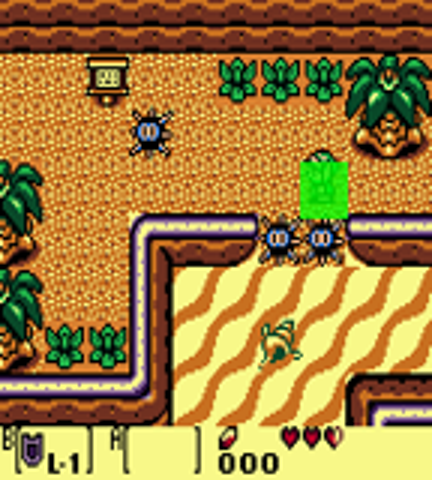

In [5]:
# Load Models for Review

models = [(int(f[:-4].split('_')[1]), f) for f in os.listdir("..//saved_models") if os.path.isfile(os.path.join("..//saved_models", f)) and f.endswith(".zip")]
models.sort()
print(models)

# Load Models for Review
lr = 0.0003
vf_coef = 0.5
ent_coef = 0.01
gamma = 0.9996

experiment_kwargs = {
    "gb_path": "..//ladx.gbc",
    "experiment_name": "test",
    "environment": "LinkAwakeningEnv",
    "lr": lr,
    "vf_coef": vf_coef,
    "ent_coef": ent_coef,
    "gamma": gamma,
    "save_state_dir": "saved_models",
    "init_state": "..//ladx.gbc.state",
    
}
env = make_vec_env(make_env(env_conf=experiment_kwargs), n_envs=1, seed=0)


obs, _, _, _ = load_environment("URCHIN", env)
image = env.env_method('get_image', **{'include_seen': True})


from IPython.display import display
import PIL
display(PIL.Image.fromarray(image[0]).resize((144*3, 160*3)))


    


In [11]:
results = []

for m in models:

    print(f"Loaded {m[0]}")
    model = PPO.load("..//saved_models//" + m[1][0:-4], env=env, ent_coef=ent_coef, n_epochs=1, gamma=gamma)

    probs0, probs1 = predict_proba(model, obs)
    action, _ = model.predict(obs, deterministic=True)
    print(action[0])
    
    data = [m[0]]
    data.extend(probs0.tolist()[0])
    data.extend(probs1.tolist()[0])
    data.append(action[0][0])
    data.append(action[0][1])

    results.append(data)





Loaded 160000
[2 0]
Loaded 320000
[3 0]
Loaded 480000
[3 2]
Loaded 640000
[3 2]
Loaded 800000
[3 2]
Loaded 960000
[3 0]
Loaded 1120000
[3 0]
Loaded 1280000
[3 0]
Loaded 1440000
[3 2]
Loaded 1600000
[3 0]
Loaded 1760000
[3 0]
Loaded 1920000
[3 0]
Loaded 2080000
[3 2]
Loaded 2240000
[3 2]
Loaded 2400000
[3 2]
Loaded 2560000
[3 2]
Loaded 2720000
[0 0]
Loaded 2880000
[1 0]
Loaded 3040000
[1 3]
Loaded 3200000
[0 3]
Loaded 3360000
[3 3]
Loaded 3520000
[3 3]
Loaded 3680000
[3 1]
Loaded 3840000
[3 3]
Loaded 4000000
[0 1]
Loaded 4160000
[3 3]
Loaded 4320000
[3 3]
Loaded 4480000
[3 3]
Loaded 4640000
[3 1]
Loaded 4800000
[3 3]
Loaded 4960000
[3 0]
Loaded 5120000
[3 3]
Loaded 5280000
[3 0]
Loaded 5440000
[3 1]


[2.54831314e-01 1.17215879e-01 3.55925411e-02 1.65103022e-02
 9.90800210e-04 8.95429228e-04 4.57208510e-03 3.15645215e-04
 4.73733060e-04 4.48439823e-04 2.13043671e-03 1.84094906e-03
 7.29911379e-04 4.22233497e-05 1.95021744e-06 1.50143886e-02
 2.63632864e-01 2.70463437e-01 1.42907709e-01 3.99172544e-01
 2.03181226e-02 1.74159033e-03 5.14839478e-02 3.96211654e-01
 7.60811210e-01 3.43638569e-01 1.54161796e-01 3.63894030e-02
 9.62775317e-04 2.59167003e-03 7.79994938e-04 2.98794452e-03
 1.42661870e-01 2.61680514e-04]


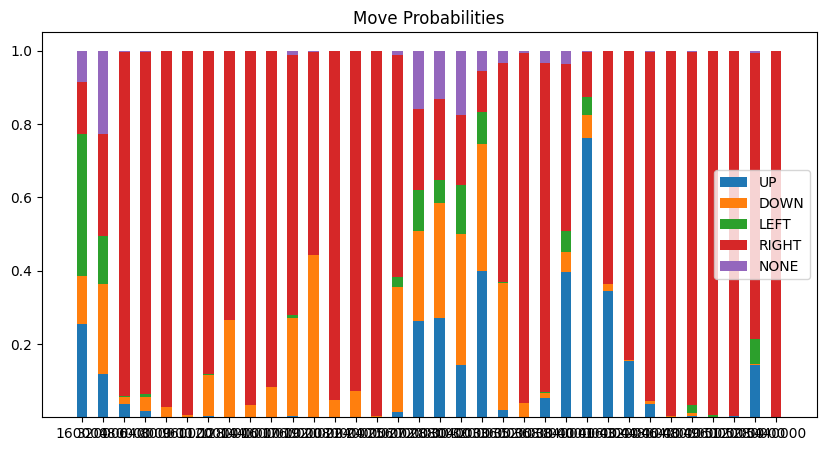

In [12]:



x = np.array([str(r[0]) for r in results])
move1 = np.array([r[1] for r in results])
move2 = np.array([r[2] for r in results])
move3 = np.array([r[3] for r in results])
move4 = np.array([r[4] for r in results])
move5 = np.array([r[5] for r in results])

button1 = np.array([r[6] for r in results])
button2 = np.array([r[7] for r in results])
button3 = np.array([r[8] for r in results])
button4 = np.array([r[9] for r in results])

move_act = np.array([r[10] for r in results])
button_act = np.array([r[11] for r in results])

weight_counts = {}
for i in range(0,5):
    weight_counts[ACTIONS_ARROW[i]] = np.array([r[i+1] for r in results])


bottom = np.zeros(len(x))

width = 0.5

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for action_name, weight_count in weight_counts.items():
    p = ax.bar(x, weight_count, width, label=action_name, bottom=bottom)
    bottom += weight_count


print(weight_counts["UP"])

ax.legend(loc='center right')
ax.set_title("Move Probabilities")



plt.show()

